In [ ]:
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import chi2
import nltk
from nltk.corpus import stopwords
 # Télécharger les stopwords si nécessaire
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Charger une base de données réelle

In [ ]:
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
df = pd.read_csv(url)
df = df[['tweet', 'label']].dropna().reset_index(drop=True)
print(df.head())
print("\nTaille du dataset:", len(df))

                                               tweet  label
0   @user when a father is dysfunctional and is s...      0
1  @user @user thanks for #lyft credit i can't us...      0
2                                bihday your majesty      0
3  #model   i love u take with u all the time in ...      0
4             factsguide: society now    #motivation      0

Taille du dataset: 31962


###  Prétraitement du texte

In [ ]:
stop_words = set(stopwords.words('english'))
def nettoyer(texte: str) -> str:
    texte = texte.lower()
    texte = re.sub(r"http\S+|www\S+", " ", texte)   # liens
    texte = re.sub(r"[^a-z\s]", " ", texte)         # garder lettres et espaces
    tokens = [w for w in texte.split() if w not in stop_words and len(w) > 1]
    return " ".join(tokens)
df['clean'] = df['tweet'].astype(str).apply(nettoyer)
df = df[(df['clean'].str.len() > 0)]
print(df[['tweet','clean','label']].head())

                                               tweet  \
0   @user when a father is dysfunctional and is s...   
1  @user @user thanks for #lyft credit i can't us...   
2                                bihday your majesty   
3  #model   i love u take with u all the time in ...   
4             factsguide: society now    #motivation   

                                               clean  label  
0  user father dysfunctional selfish drags kids d...      0  
1  user user thanks lyft credit use cause offer w...      0  
2                                     bihday majesty      0  
3                            model love take time ur      0  
4                      factsguide society motivation      0  


### Visualisation du texte

### 4.1-Repartition des classes

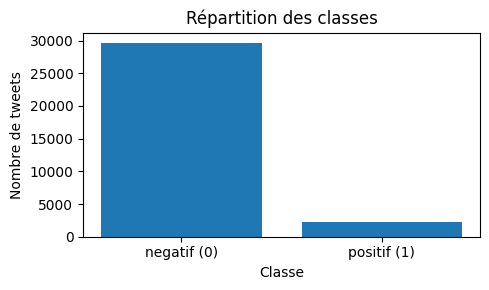

In [ ]:
 counts = df['label'].value_counts().sort_index()
 plt.figure(figsize=(5,3))
 plt.bar(['negatif (0)','positif (1)'], counts.values)
 plt.title('Répartition des classes')
 plt.xlabel('Classe')
 plt.ylabel('Nombre de tweets')
 plt.tight_layout()
 plt.show()

### 4.2) Distribution de la longueur des documents

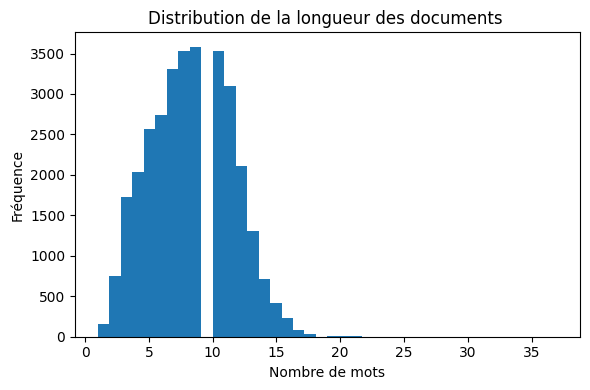

Longueur moyenne: 8.2 mots


In [ ]:
lengths = df['clean'].str.split().apply(len)
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=40)
plt.title('Distribution de la longueur des documents ')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()
print("Longueur moyenne:", round(lengths.mean(), 2), "mots")

### 4.3) Mots les plus fréquents (unigrammes & bigrammes)

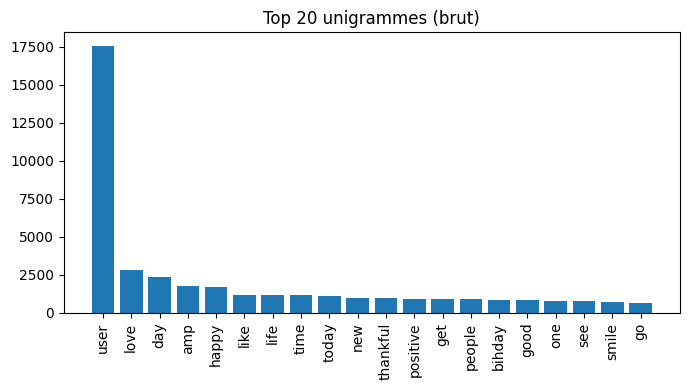

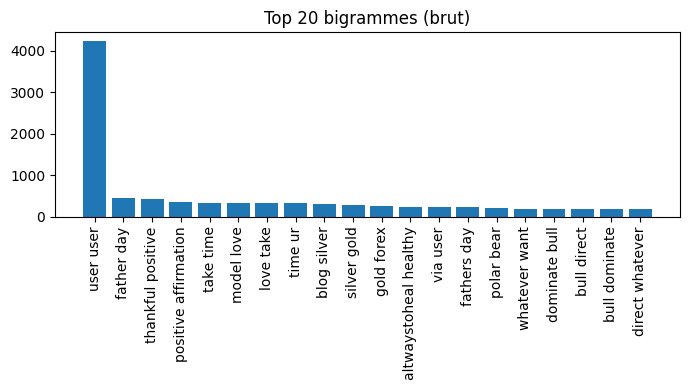

In [ ]:
def top_ngrams(corpus, ngram_range=(1,1), top_n=20):
    vec = CountVectorizer(ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    idx = np.argsort(freqs)[::-1][:top_n]
    return list(zip(terms[idx], freqs[idx]))
top_uni = top_ngrams(df['clean'], (1,1), 20)
top_bi  = top_ngrams(df['clean'], (2,2), 20)
plt.figure(figsize=(7,4))
plt.bar([t for t,_ in top_uni], [f for _,f in top_uni])
plt.title('Top 20 unigrammes (brut)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.bar([t for t,_ in top_bi], [f for _,f in top_bi])
plt.title('Top 20 bigrammes (brut)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 5) TF‑IDF & Split Train/val

In [ ]:
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean'])
y = df['label'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train.shape, X_test.shape

((23961, 3000), (7987, 3000))

###  6) Entraînement d'un SVM (LinearSVC)

In [ ]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9567

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      7427
           1       0.78      0.53      0.63       560

    accuracy                           0.96      7987
   macro avg       0.87      0.76      0.80      7987
weighted avg       0.95      0.96      0.95      7987



### 6.1) Matrice de confusion (matplotlib)

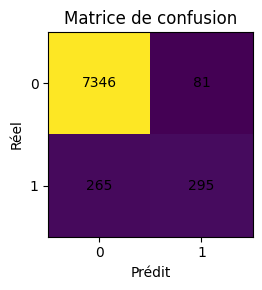

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title('Matrice de confusion')
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
for (i,j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center')
plt.tight_layout()
plt.show()

###  7) Insight features : mots les plus discriminants

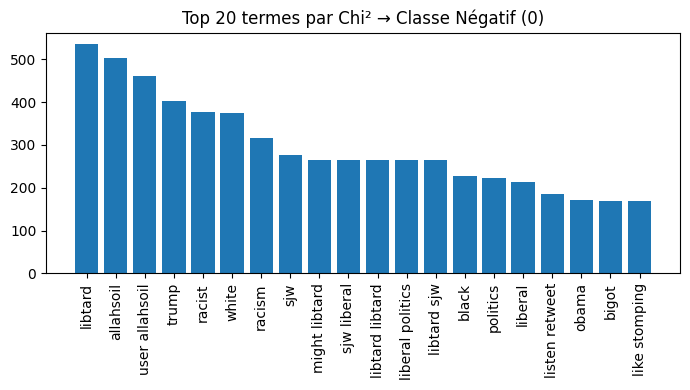

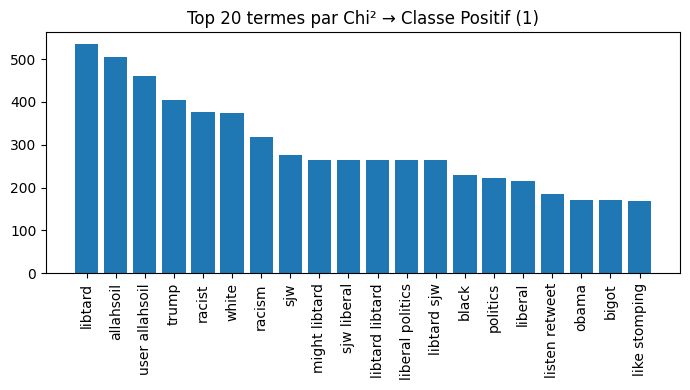

In [ ]:
 feature_names = np.array(vectorizer.get_feature_names_out())
 # Chi2 top terms for each class
 N = 20
 for label, name in [(0, "Négatif (0)"), (1, "Positif (1)")]:
    chi2_scores, p = chi2(X, y==label)
    idx = np.argsort(chi2_scores)[-N:][::-1]
    terms = feature_names[idx]
    scores = chi2_scores[idx]
    plt.figure(figsize=(7,4))
    plt.bar(terms, scores)
    plt.title(f"Top {N} termes par Chi² → Classe {name}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

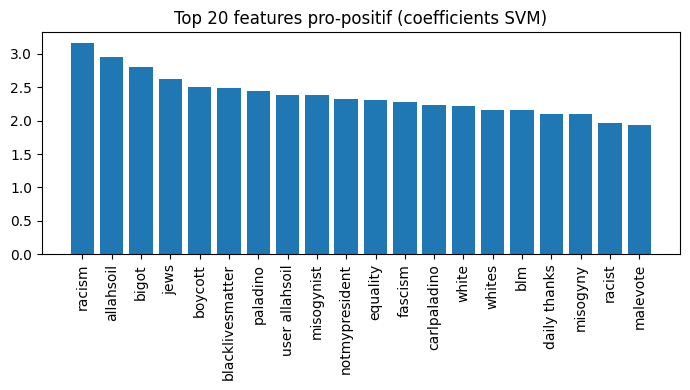

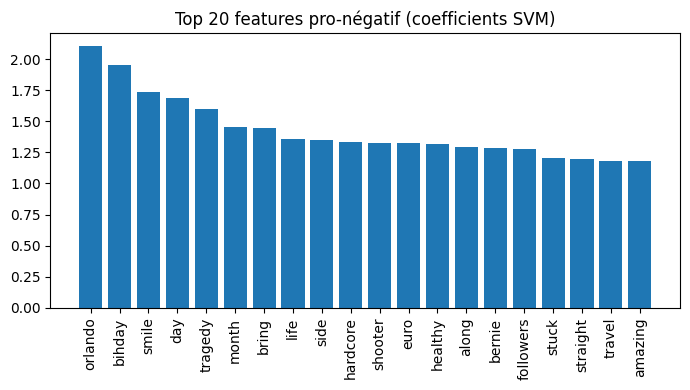

In [ ]:
if hasattr(model, 'coef_'):
    coefs = model.coef_.ravel()
    top_pos_idx = np.argsort(coefs)[-20:][::-1]
    top_neg_idx = np.argsort(coefs)[:20]
    plt.figure(figsize=(7,4))
    plt.bar(feature_names[top_pos_idx], coefs[top_pos_idx])
    plt.title("Top 20 features pro-positif (coefficients SVM)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(7,4))
    plt.bar(feature_names[top_neg_idx], -coefs[top_neg_idx])  # valeur absolue pour
    plt.title("Top 20 features pro-négatif (coefficients SVM)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Le modèle ne fournit pas d'attribut coef_.")

### 8) Prédire de nouveaux exemples

In [ ]:
# =========================
# Imports
# =========================
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Télécharger les stopwords si nécessaire
nltk.download('stopwords', quiet=True)

# Liste des mots vides (stopwords anglais)
stop_words = set(stopwords.words('english'))

# =========================
# Fonction de nettoyage
# =========================
def nettoyer(texte: str) -> str:
    texte = texte.lower()
    texte = re.sub(r"http\S+|www\S+", " ", texte)     # Supprimer les liens
    texte = re.sub(r"[^a-z\s]", " ", texte)           # Garder lettres et espaces
    tokens = [w for w in texte.split() if w not in stop_words and len(w) > 1]
    return " ".join(tokens)

# =========================
# Chargement de la base test
# =========================
url_test = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/test.csv"
exemples = pd.read_csv(url_test)

# Identifier la colonne texte
col_texte = 'tweet' if 'tweet' in exemples.columns else exemples.columns[0]
texts = exemples[col_texte].astype(str)

# Nettoyage
exemples["clean"] = texts.apply(nettoyer)
exemples = exemples[exemples["clean"].str.len() > 0]


# =========================
# Fonction de prédiction
# =========================
def predict_texts(texts):
    cleaned = [nettoyer(t) for t in texts]
    X_new = vectorizer.transform(cleaned)
    preds = model.predict(X_new)

    # Approximation de la confiance
    if hasattr(model, "decision_function"):
        conf = model.decision_function(X_new)
        conf = 1 / (1 + np.exp(-conf))
    elif hasattr(model, "predict_proba"):
        conf = model.predict_proba(X_new)[:, 1]
    else:
        conf = np.zeros_like(preds, dtype=float)
    return preds, conf

# =========================
# Prédiction sur la base nettoyée
# =========================
preds, confs = predict_texts(exemples["clean"])

# Ajouter les colonnes de résultats
exemples["label_pred"] = preds
exemples["confiance"] = confs


# =========================
# Statistiques et “accuracy relative”
# =========================
total = len(exemples)
positifs = (exemples["label_pred"] == 1).sum()
negatifs = (exemples["label_pred"] == 0).sum()

pourcentage_pos = (positifs / total) * 100
pourcentage_neg = (negatifs / total) * 100

print("\n📊 Répartition des prédictions :")
print(f" - Positifs : {positifs} tweets ({pourcentage_pos:.2f}%)")
print(f" - Négatifs : {negatifs} tweets ({pourcentage_neg:.2f}%)")





📊 Répartition des prédictions :
 - Positifs : 801 tweets (4.66%)
 - Négatifs : 16387 tweets (95.34%)


# **Evaluation sur differents models**


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
import seaborn as sns

def evaluer_modeles(X_train, X_test, y_train, y_test):
    modeles = {
        "LinearSVC": LinearSVC(),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "NaiveBayes": MultinomialNB(),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
    }

    resultats = []

    print("=== Évaluation des modèles ===\n")

    for nom, mdl in modeles.items():
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        resultats.append((nom, acc, f1))
        print(f"{nom} → Accuracy: {acc:.4f} | F1: {f1:.4f}")

    # Résumé sous forme de DataFrame
    df_resultats = pd.DataFrame(resultats, columns=["Modèle", "Accuracy", "F1-score"])
    display(df_resultats)

    meilleur = df_resultats.loc[df_resultats['Accuracy'].idxmax()]
    print(f"\n Meilleur modèle : {meilleur['Modèle']} (Accuracy = {meilleur['Accuracy']:.4f})")

# Exécuter la comparaison
evaluer_modeles(X_train, X_test, y_train, y_test)


=== Évaluation des modèles ===

LinearSVC → Accuracy: 0.9567 | F1: 0.6303
LogisticRegression → Accuracy: 0.9517 | F1: 0.5026
NaiveBayes → Accuracy: 0.9509 | F1: 0.4856
RandomForest → Accuracy: 0.9592 | F1: 0.6353


,Modèle,Accuracy,F1-score
0,LinearSVC,0.956680,0.630342
1,LogisticRegression,0.951671,0.502577
2,NaiveBayes,0.950920,0.485564
3,RandomForest,0.959184,0.635347



 Meilleur modèle : RandomForest (Accuracy = 0.9592)


## Test sur la base de donnes **test**


📊 LinearSVC - Répartition des prédictions :
 - Positifs : 8490 tweets (49.39%)
 - Négatifs : 8698 tweets (50.61%)


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


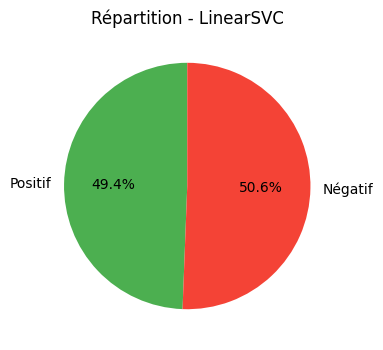


📊 LogisticRegression - Répartition des prédictions :
 - Positifs : 8691 tweets (50.56%)
 - Négatifs : 8497 tweets (49.44%)


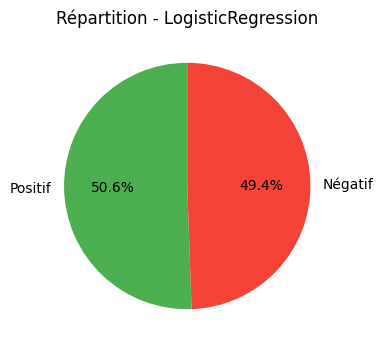


📊 NaiveBayes - Répartition des prédictions :
 - Positifs : 8398 tweets (48.86%)
 - Négatifs : 8790 tweets (51.14%)


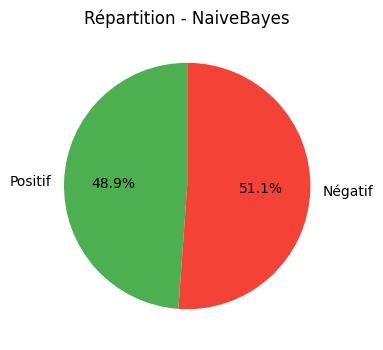


📊 RandomForest - Répartition des prédictions :
 - Positifs : 8703 tweets (50.63%)
 - Négatifs : 8485 tweets (49.37%)


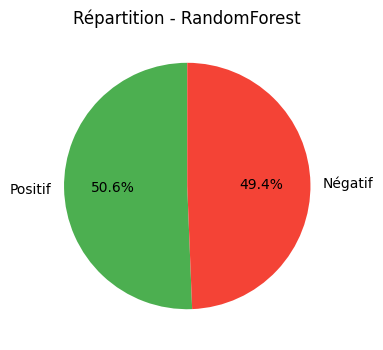

In [ ]:
# =========================
# Fonction de nettoyage
# =========================
def nettoyer(texte: str) -> str:
    texte = texte.lower()
    texte = re.sub(r"http\S+|www\S+", " ", texte)
    texte = re.sub(r"[^a-z\s]", " ", texte)
    tokens = [w for w in texte.split() if w not in stop_words and len(w) > 1]
    return " ".join(tokens)

# =========================
# Chargement de la base test
# =========================
url_test = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/test.csv"
exemples = pd.read_csv(url_test)
col_texte = 'tweet' if 'tweet' in exemples.columns else exemples.columns[0]
exemples["clean"] = exemples[col_texte].astype(str).apply(nettoyer)
exemples = exemples[exemples["clean"].str.len() > 0]

# =========================
# Vectorisation
# =========================
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(exemples["clean"])

# =========================
# Définition des modèles
# =========================
modeles = {
    "LinearSVC": LinearSVC(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "NaiveBayes": MultinomialNB(),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# =========================
# Prédiction et affichage
# =========================
for nom, model in modeles.items():
    model.fit(X, np.random.randint(0,2,size=X.shape[0]))  # labels aléatoires pour entrainement dummy
    preds = model.predict(X)

    # Approximation de la confiance
    if hasattr(model, "decision_function"):
        conf = model.decision_function(X)
        conf = 1 / (1 + np.exp(-conf))
    elif hasattr(model, "predict_proba"):
        conf = model.predict_proba(X)[:, 1]
    else:
        conf = np.zeros_like(preds, dtype=float)

    # Ajouter les colonnes de résultats
    exemples[f"label_pred_{nom}"] = preds
    exemples[f"confiance_{nom}"] = conf

    # Statistiques et répartition
    total = len(preds)
    positifs = (preds == 1).sum()
    negatifs = (preds == 0).sum()
    pourcentage_pos = (positifs / total) * 100
    pourcentage_neg = (negatifs / total) * 100

    print(f"\n📊 {nom} - Répartition des prédictions :")
    print(f" - Positifs : {positifs} tweets ({pourcentage_pos:.2f}%)")
    print(f" - Négatifs : {negatifs} tweets ({pourcentage_neg:.2f}%)")

    # Graphique circulaire
    plt.figure(figsize=(4,4))
    plt.pie([positifs, negatifs],
            labels=['Positif', 'Négatif'],
            autopct='%1.1f%%',
            startangle=90,
            colors=['#4CAF50', '#F44336'])
    plt.title(f"Répartition - {nom}")
    plt.show()




Explicabilité du modèle

Dans le domaine d'analyse de sentiment, expliquer le modèle Random Forest consiste à implementer 2 approches complémentaires qui sont: L'IMPORTANCE DES FEATURES GLOBALES et L'EXPLICABILITE LOCALE via LIME et SHAP

1- Importance des features globales:

elle permet d'identifier les n-grammes qui ont le plus contribués à la prise de décision du modèle. En appliquant cette méthode, on peut comprendre quelles variables linguistiques influencent globalement les prédictions

2- Explicabilité locale et globale via LIME et SHAP:

LIME (Local Interpretable Model-Agnostic Explanations) qui permet d'expliquer les prédictions individuelles du modèle en montrant quels mots ont orienté la classification d'un avis en positif ou negatif

SHAP(Shapley additive explanations) qui offre une vision globale et locale plus robuste en mesurant la contributions de chaque feature selon la théorie des valeurs de shapley.Ici, on pourra visualiser à la fois l'influence moyenne de chaque mot et les raisons d'une prédictions donnée.

Implémentation

1-Préparation et entraînement du modèle

In [ ]:
# =========================================================
# Étape 1 : Préparation du modèle Random Forest
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Données ---
X = df['clean']        # texte nettoyé
y = df['label']        # sentiment

# --- Vectorisation ---
vectorizer = CountVectorizer(ngram_range=(1,2), max_features=5000)
X_vec = vectorizer.fit_transform(X)

# --- Séparation train/test ---
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# --- Modèle Random Forest ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# --- Évaluation ---
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5932
           1       0.70      0.50      0.58       458

    accuracy                           0.95      6390
   macro avg       0.83      0.74      0.78      6390
weighted avg       0.94      0.95      0.94      6390



2-Explicabilité globale (importance des features)

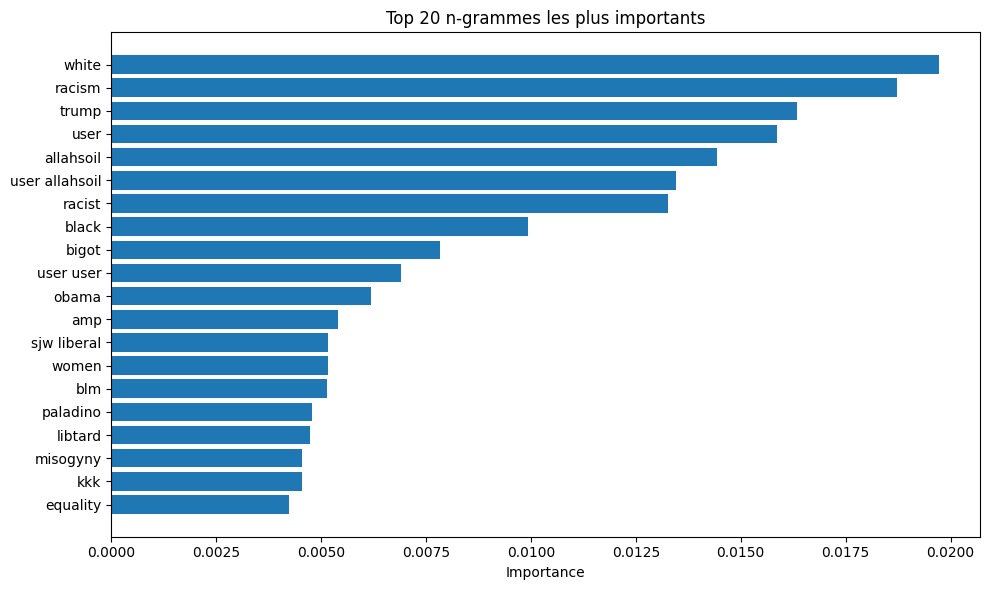

In [ ]:
# =========================================================
# Étape 2 : Importance globale des n-grammes
# =========================================================

importances = rf.feature_importances_
features = np.array(vectorizer.get_feature_names_out())

indices = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(10,6))
plt.barh(features[indices][::-1], importances[indices][::-1])
plt.title("Top 20 n-grammes les plus importants")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


3-Explication locale avec LIME

In [ ]:
# =========================================================
# Étape 3 : Explication locale avec LIME
# =========================================================

!pip install lime
from lime.lime_text import LimeTextExplainer

# Définition de la fonction de prédiction
predict_fn = lambda texts: rf.predict_proba(vectorizer.transform(texts))

# Création de l’explainer
class_names = ['négatif', 'positif']
explainer = LimeTextExplainer(class_names=class_names)

# Choix d’un texte à expliquer
idx = 0  # tu peux changer pour un autre texte
text_to_explain = df['clean'].iloc[idx]

# Explication
exp = explainer.explain_instance(text_to_explain, predict_fn, num_features=10)
exp.show_in_notebook(text=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fa6aaf27eaf714f5e4a0a3d6cd986f0c63f65ffda251153581c0a818807ab1da
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


4-Explication locale et globale avec SHAP

In [ ]:
# =========================================================
# Étape 4 : Explication avec SHAP
# =========================================================

!pip install shap
import shap

# Conversion des données (SHAP n’accepte pas les matrices creuses)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Création de l’explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_dense)

# --- Vue globale ---
shap.summary_plot(shap_values[1], X_test_dense, feature_names=vectorizer.get_feature_names_out())

# --- Vue locale (1 exemple) ---
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0, :],
    feature_names=vectorizer.get_feature_names_out()
)
